In [1]:
from subgraph.datasets import multiwoz
from minicache import cached_step, init, MetadataStorage, Cache
from dialogue_sim.utils import plot_pairwaise_class
import numpy as np
import seaborn as sns

sns.set_theme(style = 'darkgrid', font_scale = 1.5)
init(meta=MetadataStorage(), cache=Cache())

Cache for init not found, caclulating...
Done


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
train, test = multiwoz()

NameError: name 'multiwoz' is not defined

In [77]:
import numpy as np
from sklearn.metrics import roc_auc_score

def service_classification_metrics(sim_metric, test_data, num_repeats = 1000):
    n_dialogues = len(test_data)
    idxs = np.random.choice(range(n_dialogues), size = (num_repeats, 2))
    dialogues = [(test_data[i], test_data[j]) for (i, j) in idxs]
    services = [(dial[0].services, dial[1].services) for dial in dialogues]
    target = np.array([len(set(serv[0]) & set(serv[1])) > 0 for serv in services]).astype('int')
    #target = np.array([set(serv[0]) == set(serv[1]) for serv in services]).astype('int')
    scores = []
    for i in range(num_repeats):
        metric = sim_metric(*dialogues[i])
        scores.append(metric)
    scores = np.array(scores)
    return roc_auc_score(target, scores), scores, target

In [78]:
const_metr = lambda x, y : 0
auc, scores, target = service_classification_metrics(const_metr, test_dials, 1000)
print(auc)

0.5


# Sentence embeddings

## Mean Convert embeddings

In [6]:
EMB_PATH = "embeddings/multiwoz/"
convert_test_emb = np.load(EMB_PATH + 'test_convert_context.np.npy')

def get_conv_emb(dial):
    dial1_idx = test.get_dialog_start_idx(dial)
    res = []
    for i in range(len(dial)):
        res.append(convert_test_emb[dial1_idx + i])
    return np.array(res)

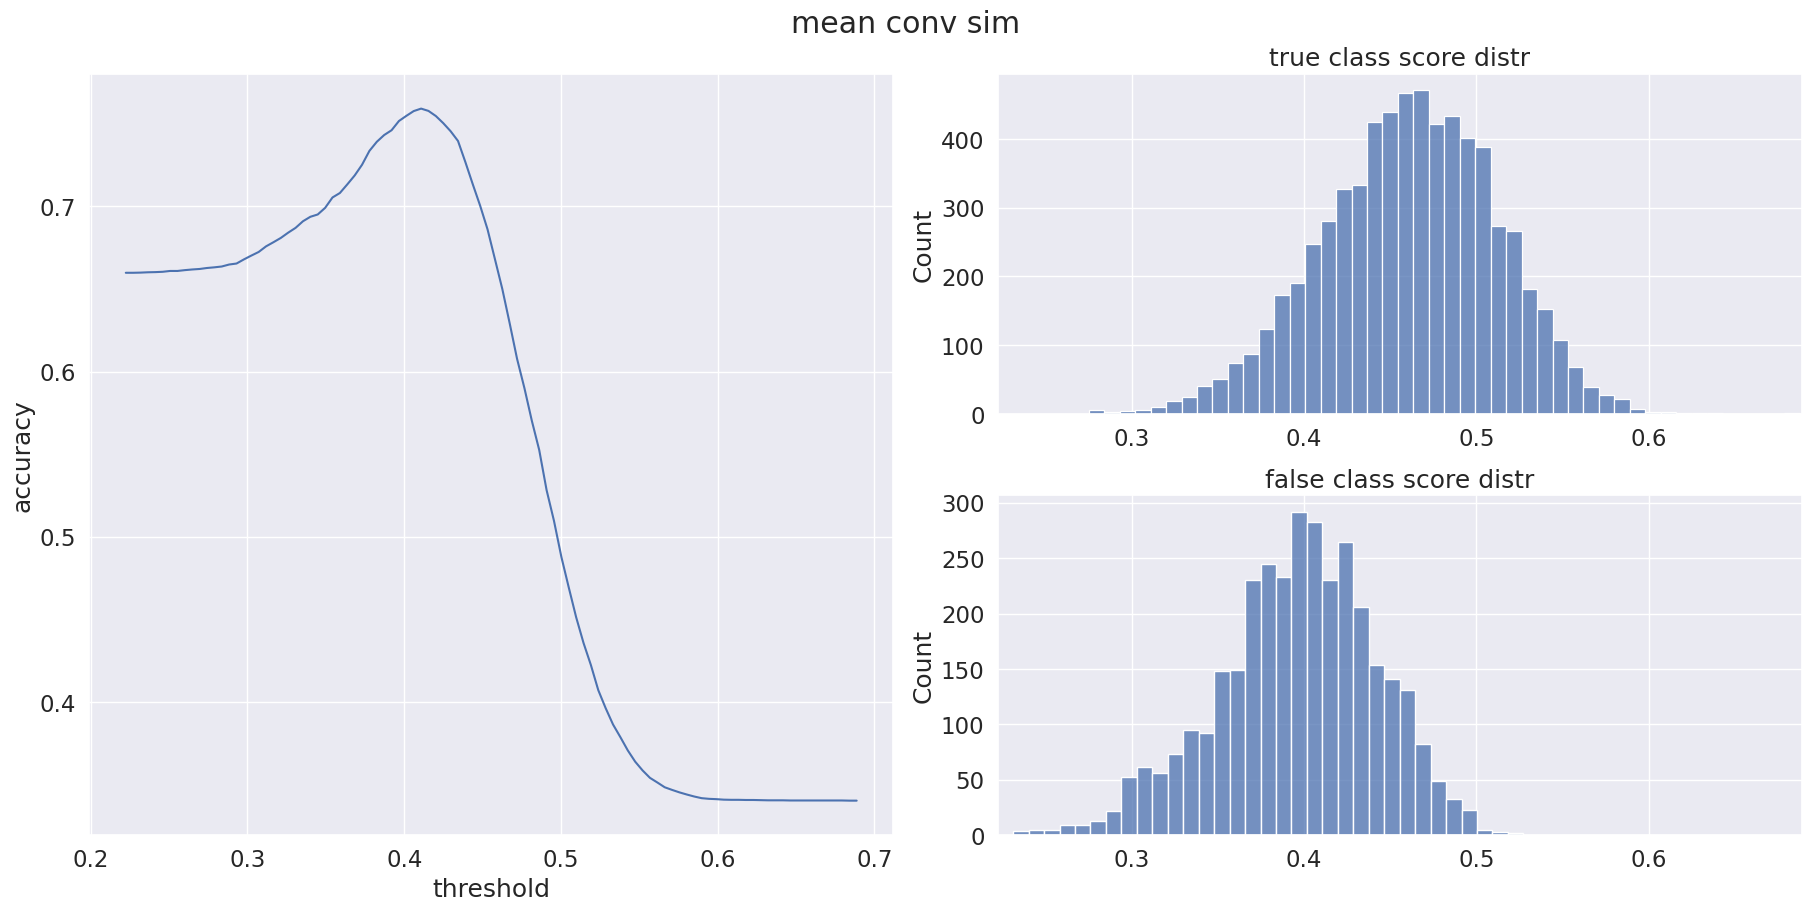

max acc: 0.759
class 1 prop : 0.6598
auc :  0.8280


In [120]:
from dialogue_sim.sim_metrics import mean_lm_embeddings

auc, scores, target = service_classification_metrics(mean_lm_embeddings, test_dials, 10000)
max_acc = plot_pairwaise_class(scores, target, "mean conv sim")
print(f'auc : {auc : .4f}')
results = {}
results['mean conv emb'] = [max_acc, auc]

## Last convert embedding

In [8]:
def last_conv_emb_sim(dial1, dial2):
    dial1_idx = test.get_dialog_start_idx(dial1) + len(dial1) - 1
    dial2_idx = test.get_dialog_start_idx(dial2) + len(dial2) - 1
    return (convert_test_emb[dial1_idx] * convert_test_emb[dial2_idx]).sum()

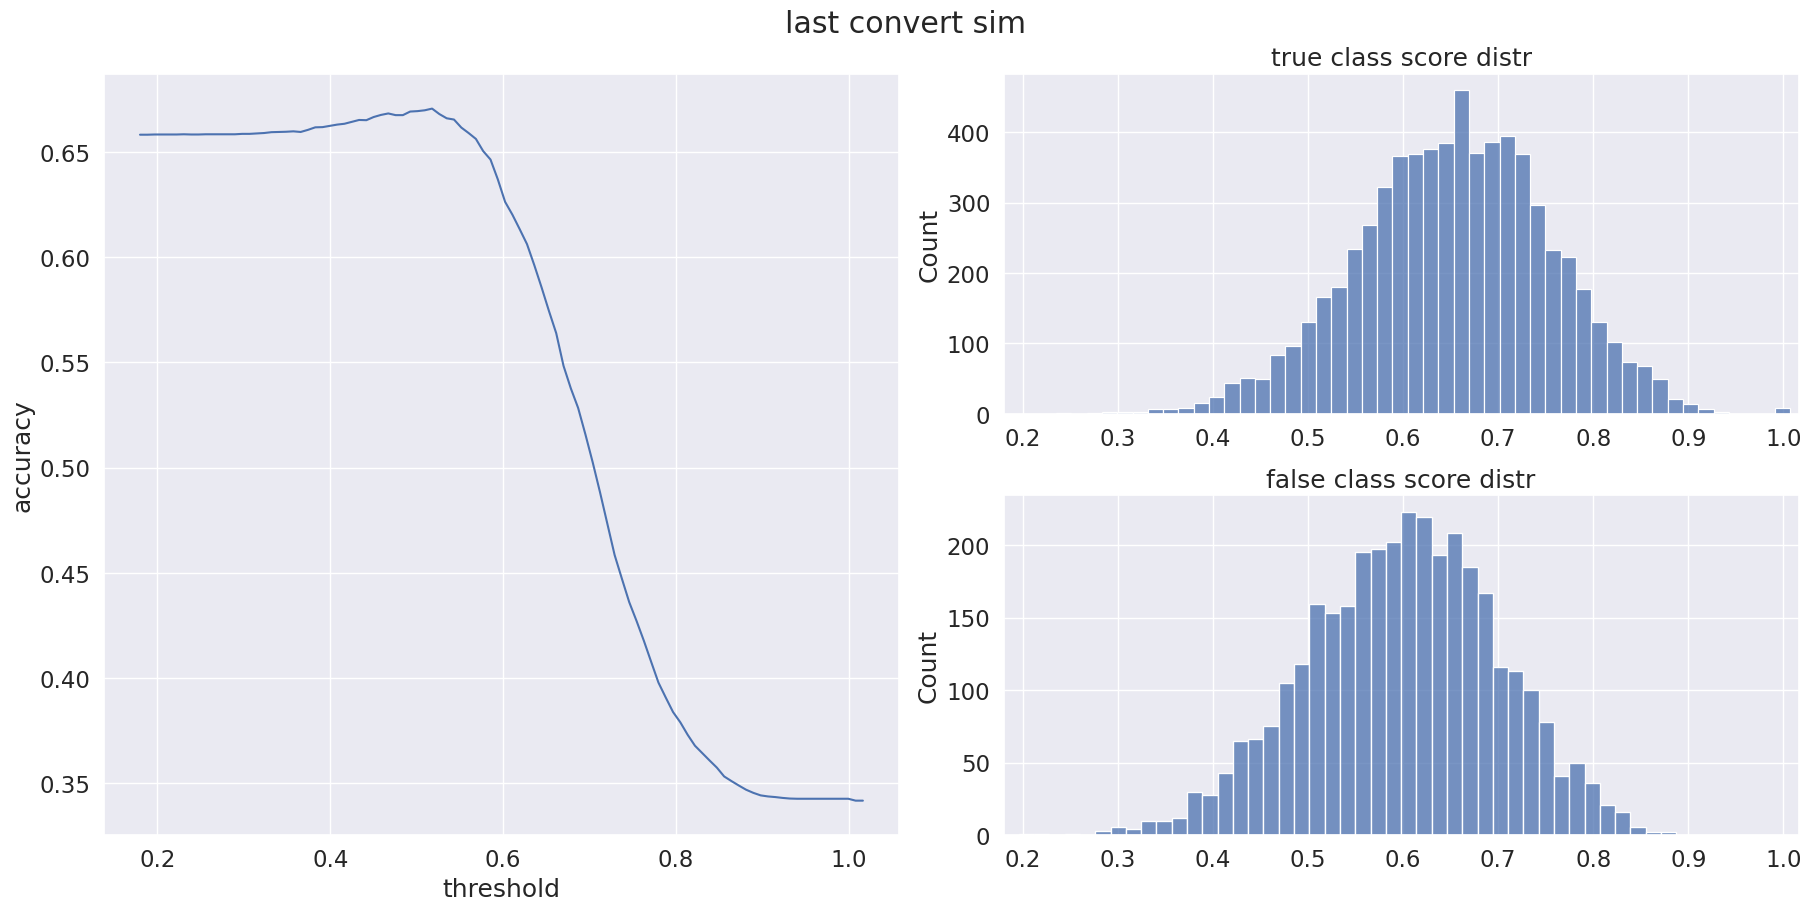

max acc: 0.671
class 1 prop : 0.6582
auc :  0.6475


In [9]:
auc, scores, target = service_classification_metrics(last_conv_emb_sim, test, 10000)
max_acc = plot_pairwaise_class(scores, target, "last convert sim")
print(f'auc : {auc : .4f}')
results['last convert emb'] = [max_acc, auc]

In [5]:
from embedders import CachedEmbeddings
from dgac import dgac_two_stage

EMB_PATH = 'embeddings/multiwoz/sentence_bert_{split}_embeddings.npy'
CONV_EMB_PATH = 'embeddings/multiwoz/{split}_convert_context.np.npy'

train_emb = np.load(EMB_PATH.format(split = 'train'))
test_emb = np.load(EMB_PATH.format(split = 'test'))

conv_train_emb = np.load(CONV_EMB_PATH.format(split = 'train'))
conv_test_emb = np.load(CONV_EMB_PATH.format(split = 'test'))

embedder = CachedEmbeddings(
    dialogues=train,
    embeddings=train_emb,
    test_dialogues=test,
    test_embeddings=test_emb
)
conv_embedder = CachedEmbeddings(
    dialogues= train,
    embeddings= conv_train_emb,
    test_dialogues= test,
    test_embeddings= conv_test_emb
)

In [ ]:
import pickle
from dgac import dgac_two_stage

graph_2_60_sbert = dgac_two_stage(train, embedder, n_clusters_first_stage = {"SYSTEM" : 200, "USER"  : 200},
                            n_clusters={"SYSTEM" : 30, "USER" : 30}, verbosity=-1)

with open('dialogue_sim/graphs/graph_2_60_sbert.pkl', 'wb') as file:
    pickle.dump(graph_2_60_sbert, file)

In [6]:
import pickle

with open('dialogue_sim/graphs/graph_2_60_sbert.pkl', 'rb') as file:
    graph_2_60_sbert = pickle.load(file)

## Saving data

In [7]:
from dialogue_sim.dialogue_data import DialogueData

train_dials = [DialogueData(d, train, train_emb, graph_2_60_sbert) for d in train]
test_dials = [DialogueData(d, test, test_emb, graph_2_60_sbert) for d in test]

with open("dialogue_sim/data/mwtrain_sbert.pkl", "wb") as file:
    pickle.dump(train_dials, file)

with open("dialogue_sim/data/mwtest_sbert.pkl", "wb") as file:
    pickle.dump(test_dials, file)

In [3]:
import pickle

with open("dialogue_sim/data/mwtrain_sbert.pkl", "rb") as file:
    train_dials = pickle.load(file)

with open("dialogue_sim/data/mwtest_sbert.pkl", "rb") as file:
    test_dials = pickle.load(file)

# Second stage embeddings

## Mean Sbert second stage embeddings

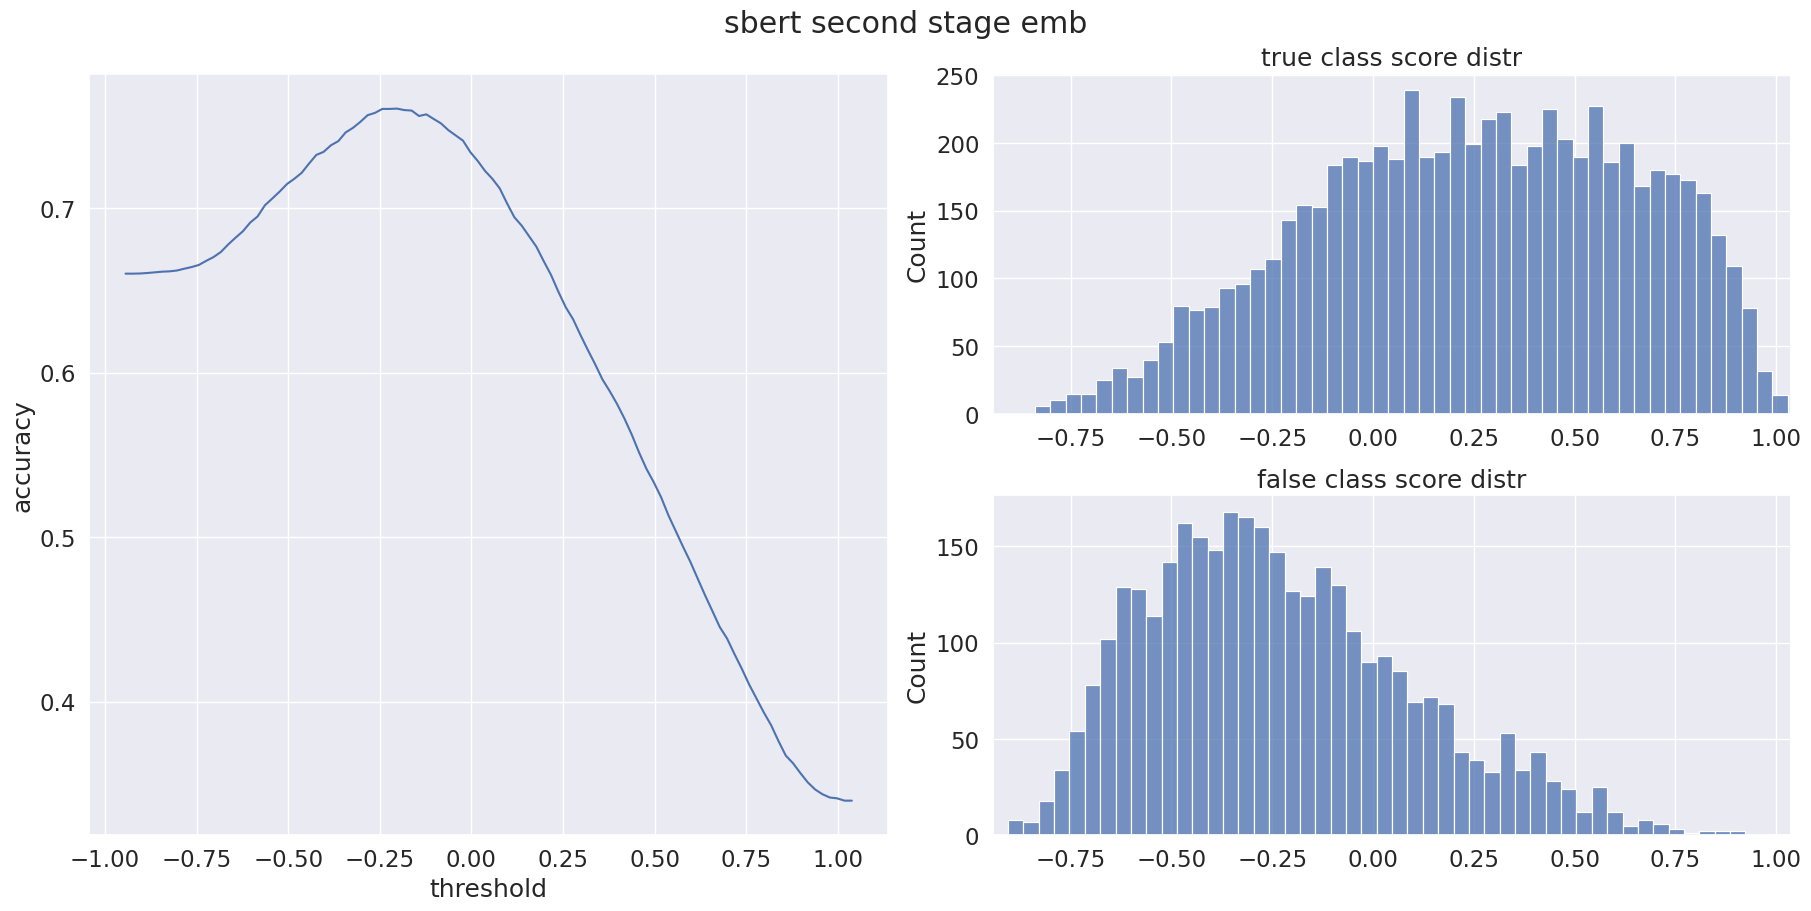

max acc: 0.761
class 1 prop : 0.6603
auc :  0.8172


In [117]:
from dialogue_sim.utils import plot_pairwaise_class
from dialogue_sim.sim_metrics import mean_first_stage_emb

auc, scores, target = service_classification_metrics(mean_first_stage_emb, test_dials, 10000)
max_acc = plot_pairwaise_class(scores, target, "sbert second stage emb")
print(f'auc : {auc : .4f}')
results['sbert 2nd stage emb'] = [max_acc, auc]

In [ ]:
import pickle
from dgac import dgac_two_stage

graph_2_60 = dgac_two_stage(train, conv_embedder, n_clusters_first_stage = {"SYSTEM" : 200, "USER"  : 200},
                            n_clusters={"SYSTEM" : 30, "USER" : 30}, verbosity=200)

with open('dialogue_sim/graphs/graph_2_60_convert_context.pkl', 'wb') as file:
    pickle.dump(graph_2_60, file)

In [82]:
with open('dialogue_sim/graphs/graph_2_60_convert_context.pkl', 'rb') as file:
    graph_2_60 = pickle.load(file)

In [118]:
train_dials = [DialogueData(d, train, conv_train_emb, graph_2_60) for d in train]
test_dials = [DialogueData(d, test, conv_test_emb, graph_2_60) for d in test]

with open("dialogue_sim/data/mwtrain_sbert.pkl", "wb") as file:
    pickle.dump(train_dials, file)

with open("dialogue_sim/data/mwtest_sbert.pkl", "wb") as file:
    pickle.dump(test_dials, file)

## Mean ConveRT second stage embeddings

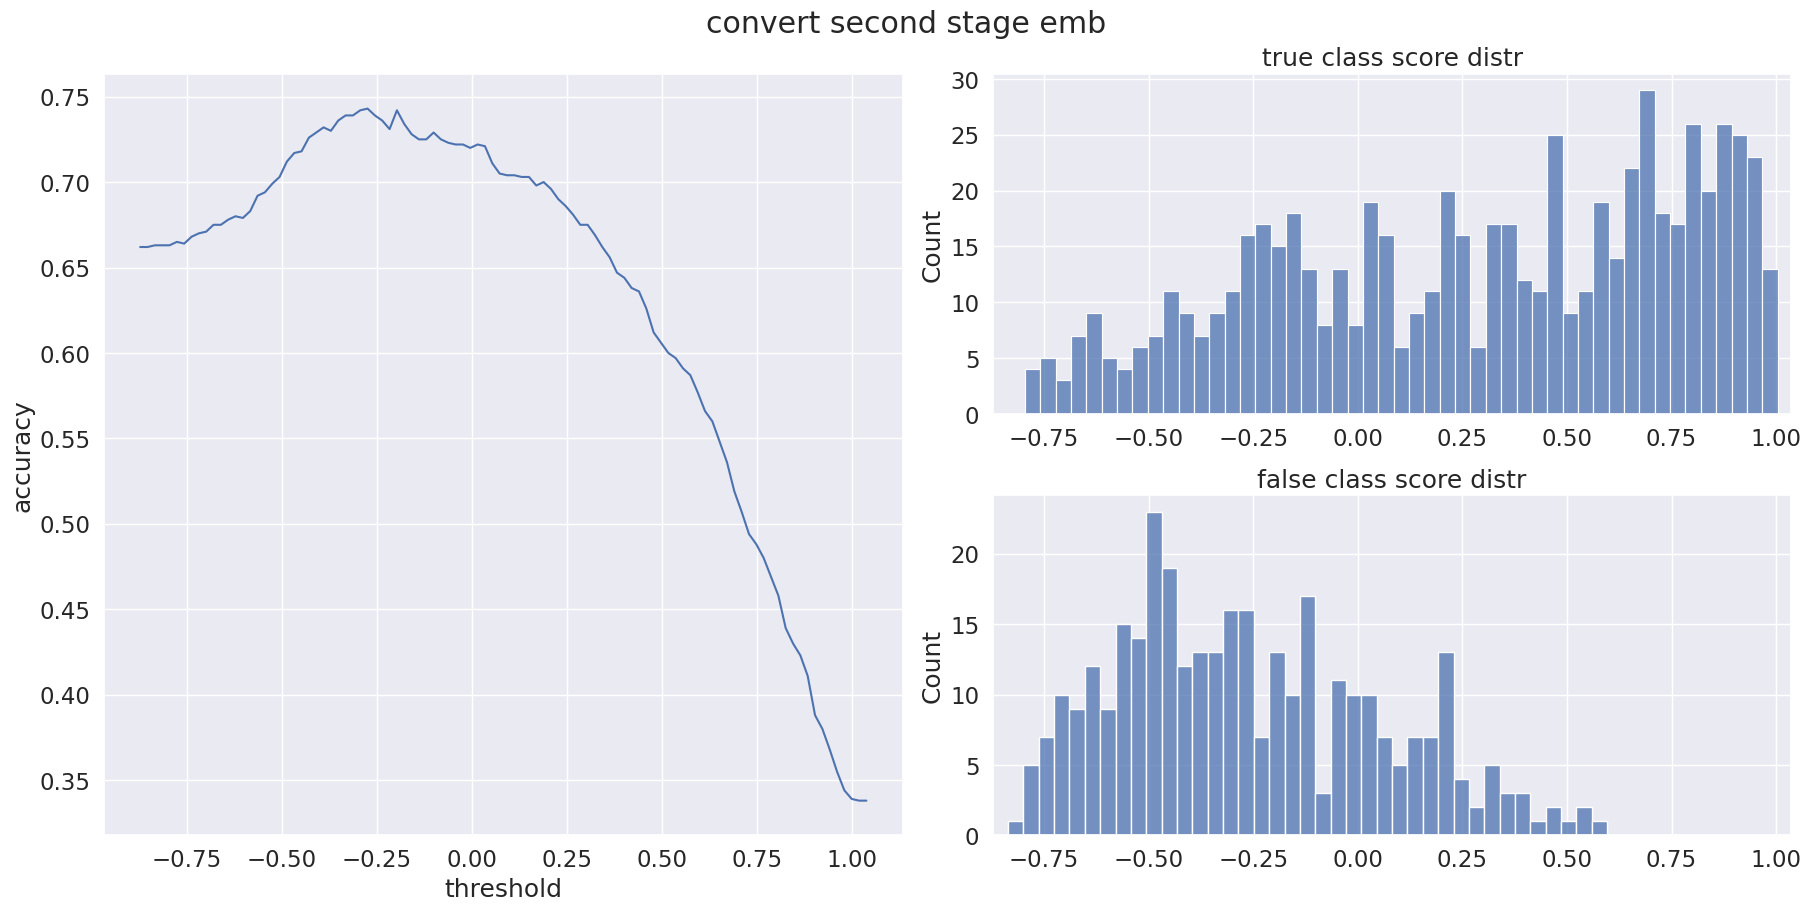

max acc: 0.743
class 1 prop : 0.662
auc :  0.8137


In [119]:
from dialogue_sim.utils import plot_pairwaise_class

auc, scores, target = service_classification_metrics(mean_first_stage_emb, test_dials, 1000)
max_acc = plot_pairwaise_class(scores, target, "convert second stage emb")
print(f'auc : {auc : .4f}')
results['convert 2nd stage emb'] = [max_acc, auc]

# Graph Metrics

## Node intersection

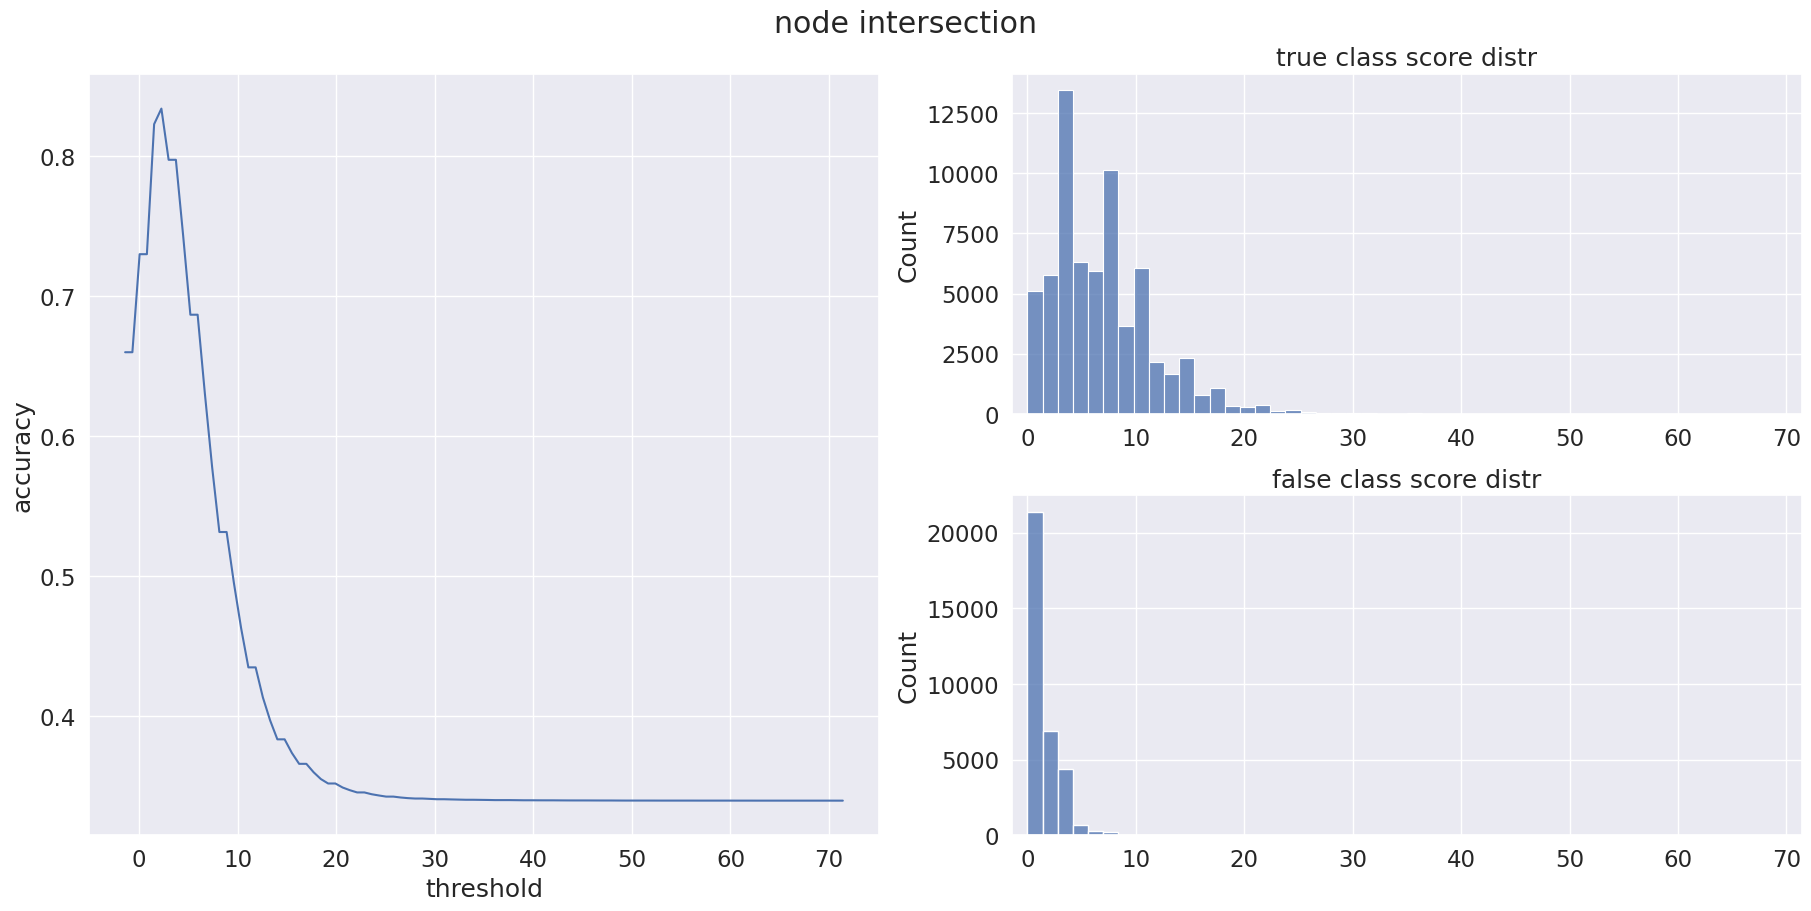

max acc: 0.834
class 1 prop : 0.66017
auc :  0.9034


In [89]:
from dialogue_sim.sim_metrics import node_intersection

auc, scores, target = service_classification_metrics(node_intersection, test_dials, 100000)
max_acc = plot_pairwaise_class(scores, target, "node intersection")
print(f'auc : {auc : .4f}')
results['node intersection'] = [max_acc, auc]

## Dice

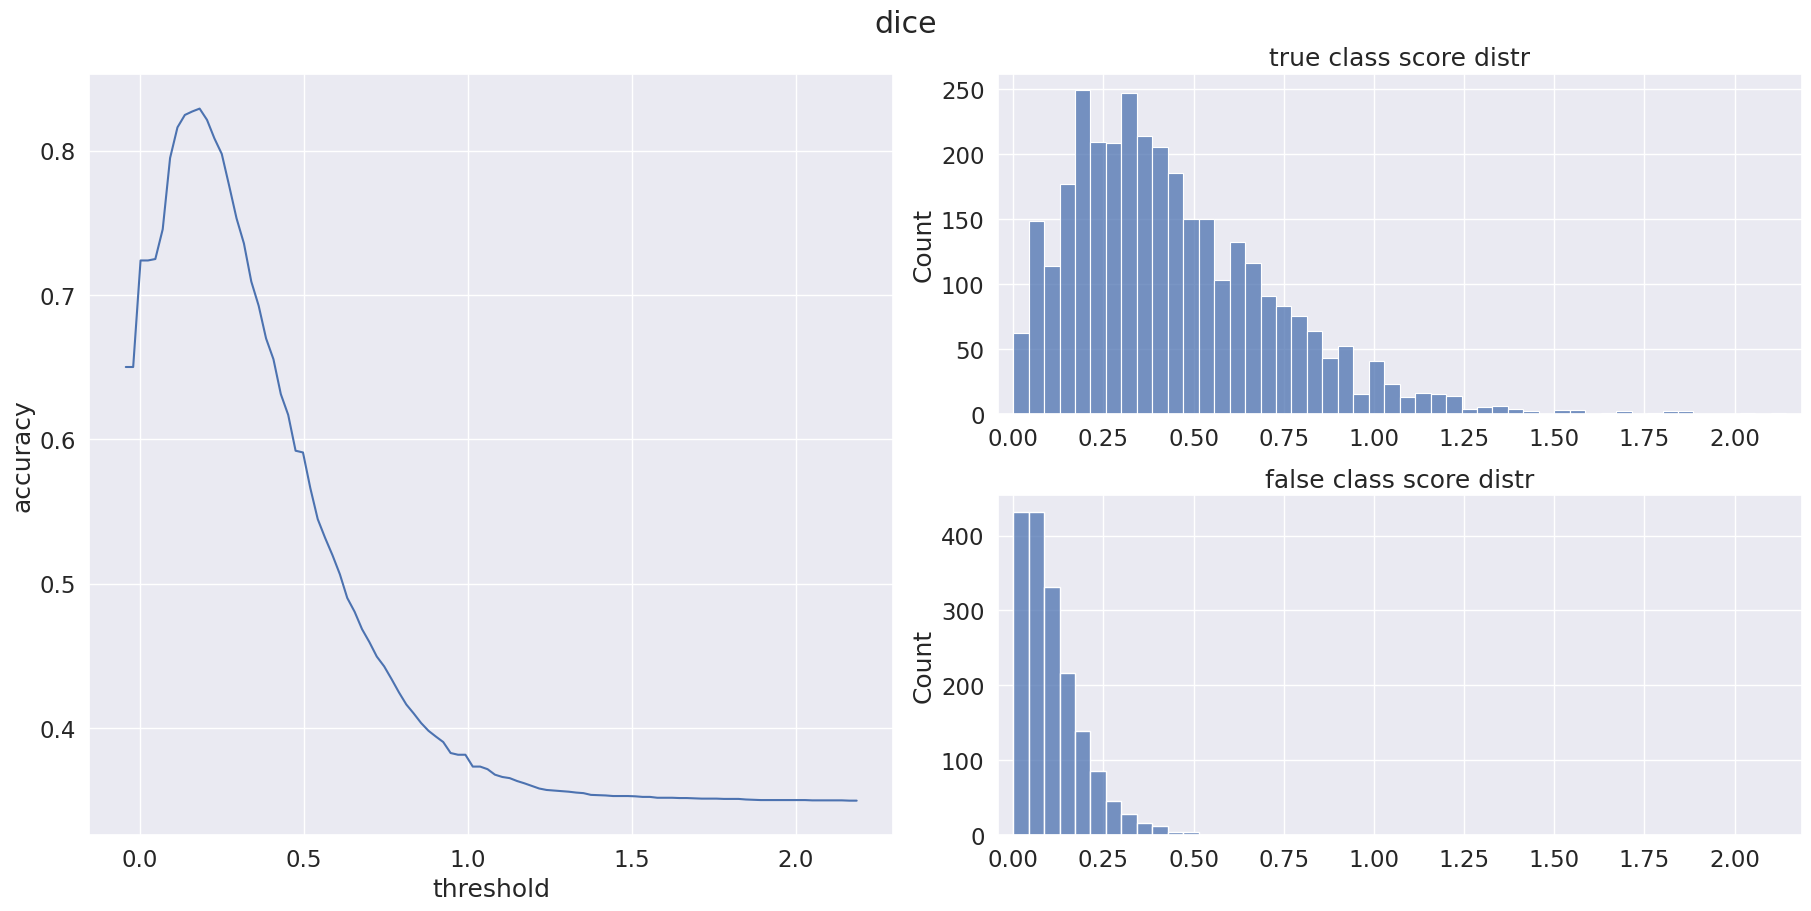

max acc: 0.829
class 1 prop : 0.6502
auc :  0.9020


In [90]:
from dialogue_sim.sim_metrics import dice

auc, scores, target = service_classification_metrics(dice, test_dials, 5000)
max_acc, plot_pairwaise_class(scores, target, 'dice')
results['dice'] = [max_acc, auc]
print(f'auc : {auc : .4f}')

## Distribution minimum

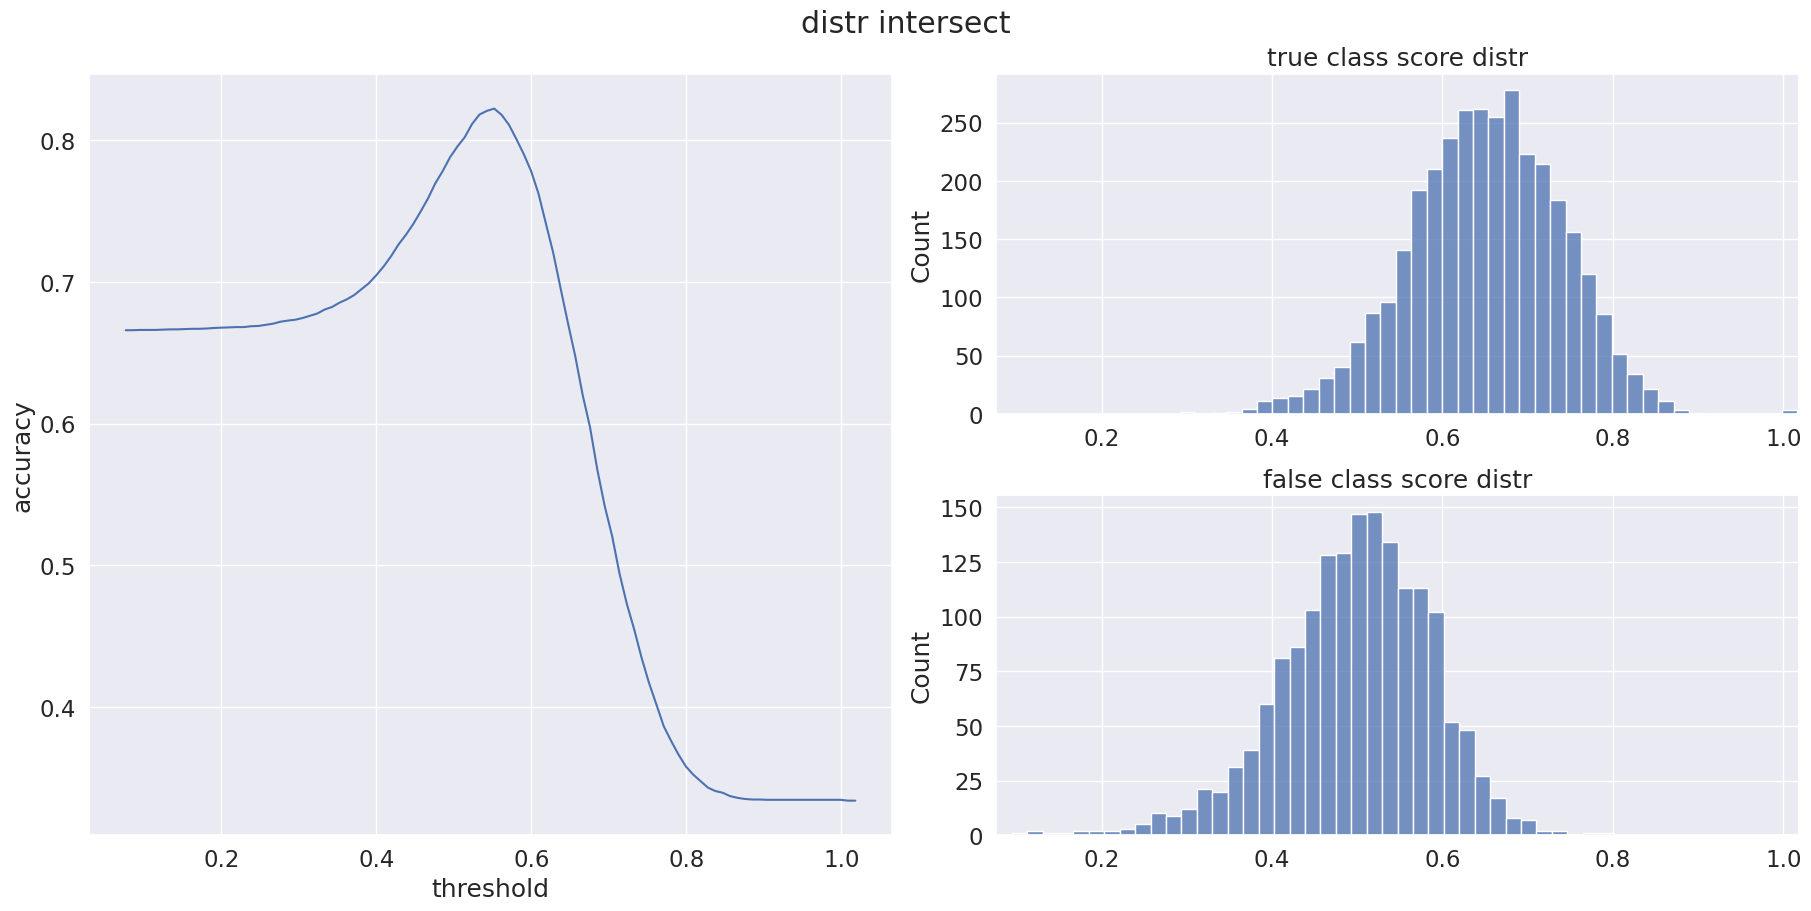

max acc: 0.822
class 1 prop : 0.666
auc :  0.8913


In [129]:
from dialogue_sim.sim_metrics import distr_intersect
    
auc, scores, target = service_classification_metrics(distr_intersect, test_dials, 5000)
max_acc = plot_pairwaise_class(scores, target, 'distr intersect')
print(f'auc : {auc : .4f}')
results['distr intersect'] = [max_acc, auc]

## JS divergence

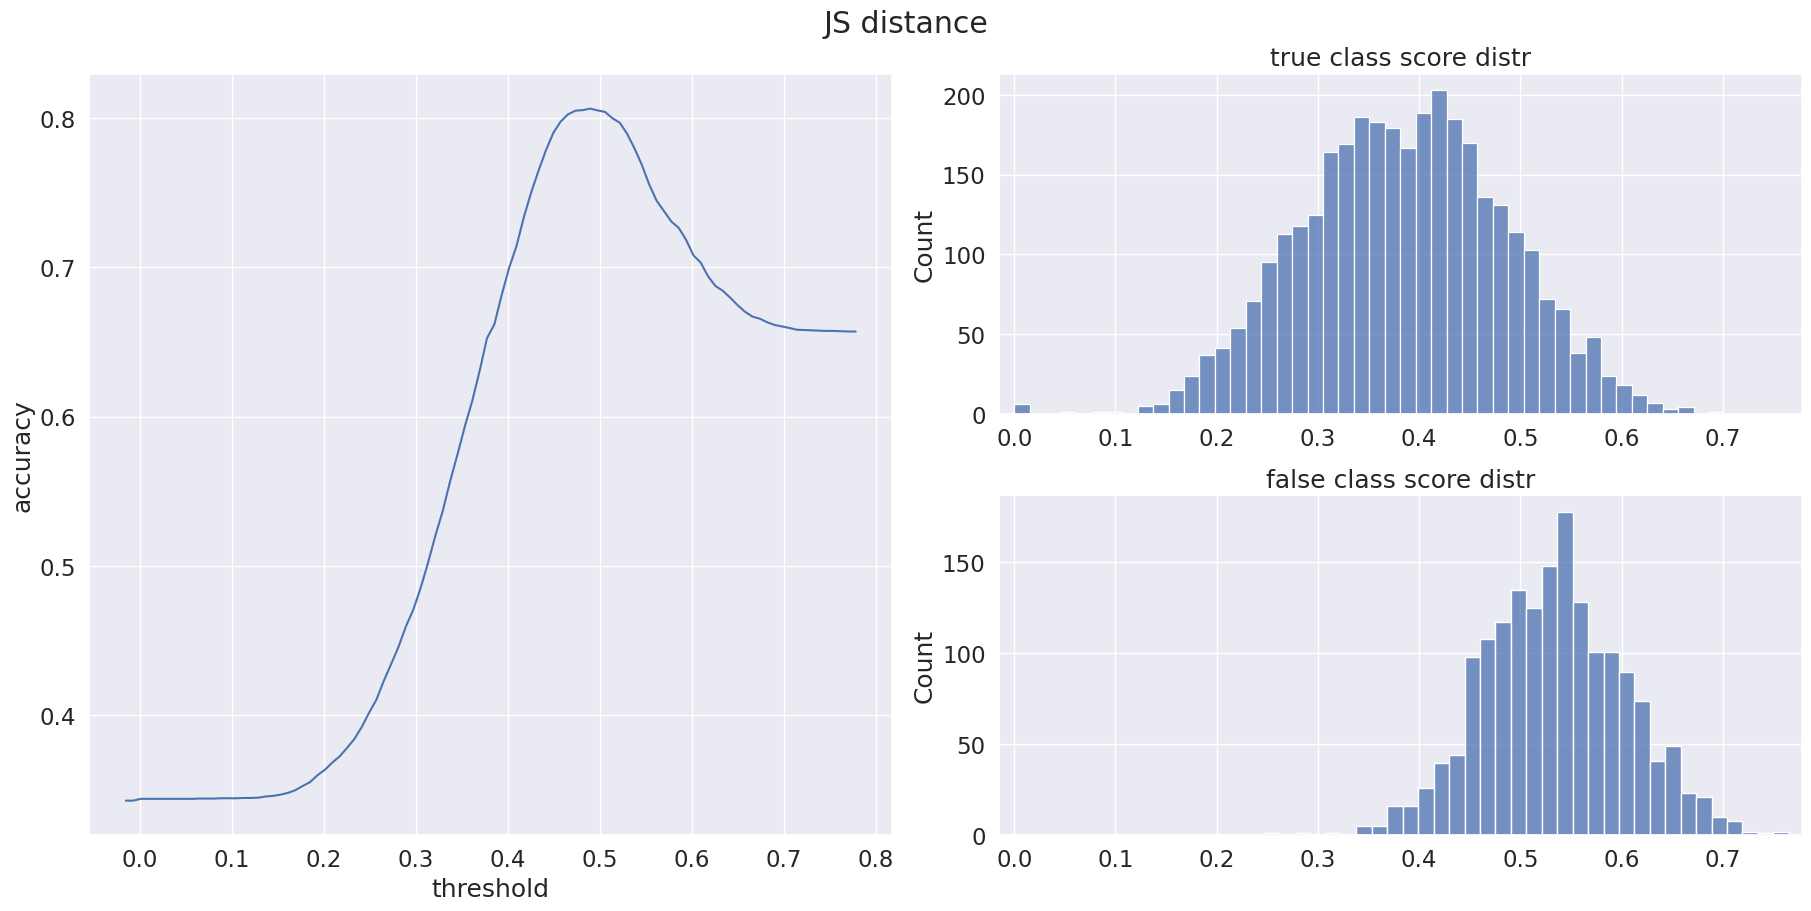

max acc: 0.806
class 1 prop : 0.657
auc :  0.8884


In [94]:
from dialogue_sim.sim_metrics import JS_distance

auc, scores, target = service_classification_metrics(lambda x, y :JS_distance(x, y, graph_2_60), test_dials, 5000)
max_acc = plot_pairwaise_class(scores, target, "JS distance", lt = True)
results['JS distance'] = [max_acc, 1 - auc]
print(f'auc : {1 - auc : .4f}')

## Distribution cosine

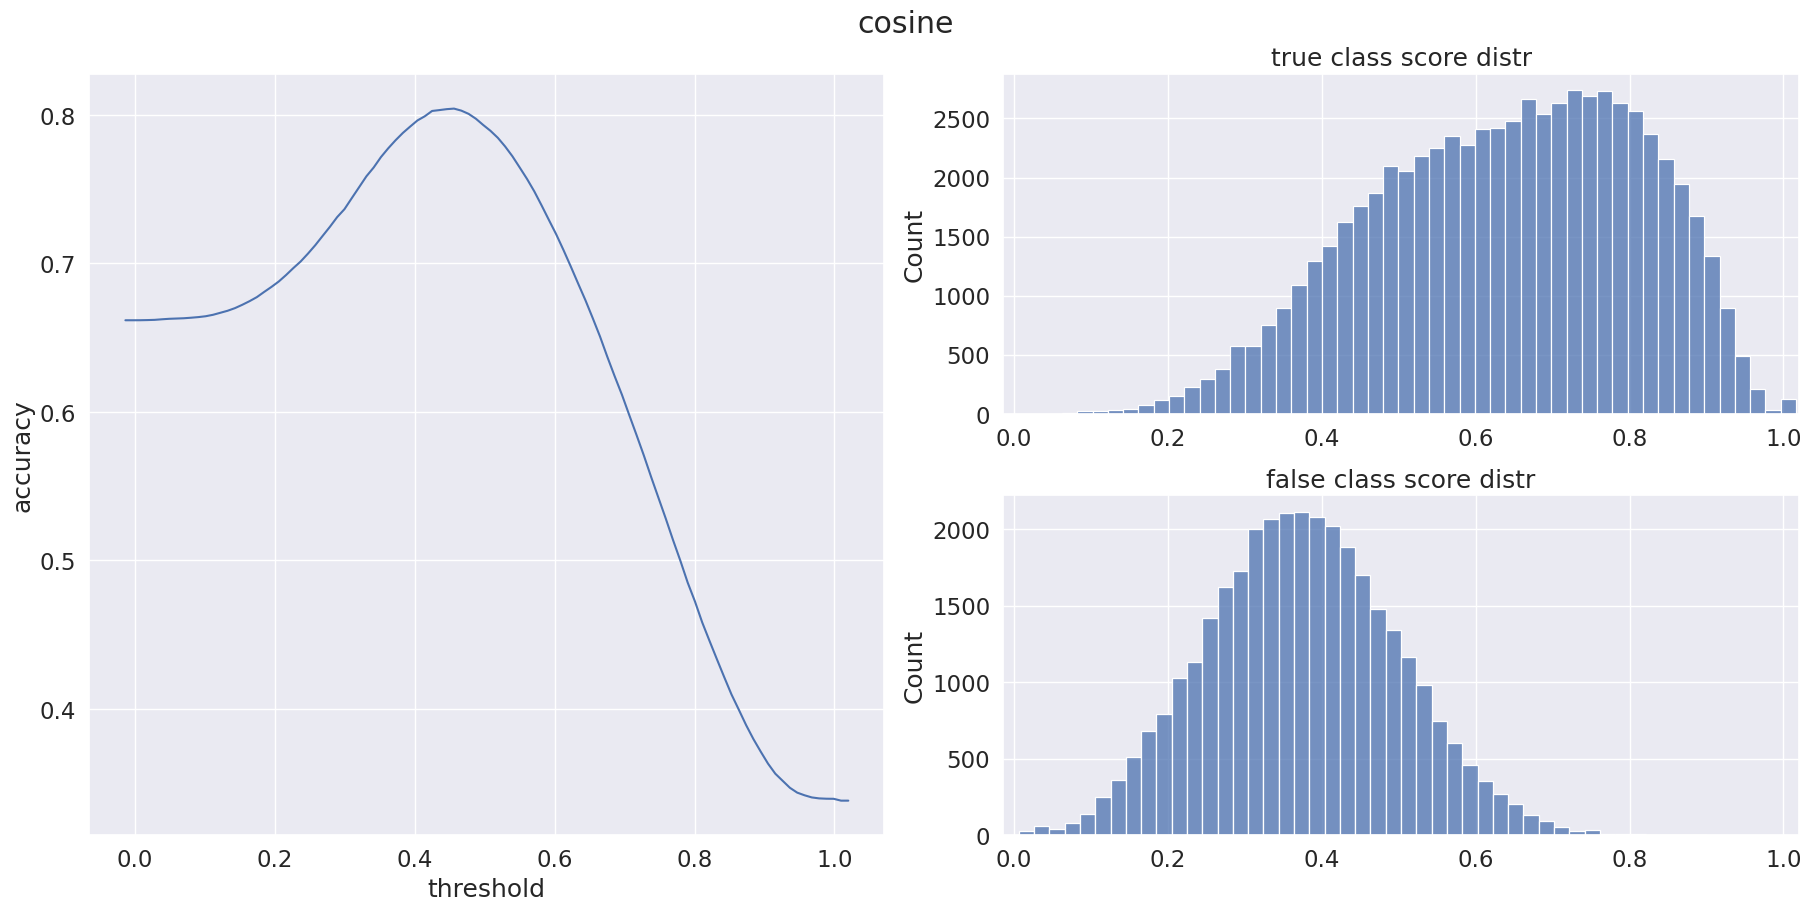

max acc: 0.804
class 1 prop : 0.66175
auc :  0.8846


In [101]:
from dialogue_sim.sim_metrics import distr_cosine

auc, scores, target = service_classification_metrics(lambda x, y : distr_cosine(x, y, graph_2_60), test_dials, 100000)
max_acc = plot_pairwaise_class(scores, target, 'cosine')
results['cosine'] = [max_acc, auc]
print(f'auc : {auc : .4f}')

In [100]:
import pandas as pd

acc = []
auc = []
name = []
for k, v in results.items():
    name.append(k)
    acc.append(v[0])
    auc.append(v[1])

res = pd.DataFrame({'acc' : acc, 'auc' : auc})
res.index = name
res.sort_values('acc', ascending = False)

,acc,auc
node intersection,0.83421,0.903362
dice,0.83421,0.902015
distr intersect,0.82600,0.898856
JS distance,0.80620,0.888424
cosine,0.80280,0.881711
mean conv emb,0.76900,0.834209
sbert 2nd stage emb,0.75820,0.814453
last convert emb,0.67060,0.647456


In [4]:
from tqdm.notebook import tqdm
import pandas as pd

def sample_pairs(metric_eval, data, num_repeats = 10000):
    n_dialogues = len(data)
    dials = np.random.choice(data, size = (num_repeats, 2))
    target = np.array([len(set(dial[0].services) & set(dial[1].services)) > 0 for dial in dials]).astype('int')
    scores = []
    for i in tqdm(range(num_repeats)):
        metrics = metric_eval.get_metrics(*dials[i])
        scores.append(list(metrics.values()))
    scores = np.array(scores)
    df = pd.DataFrame(scores, columns = list(metrics.keys()))
    df['target'] = target
    return df

In [5]:
%cd dialogue_sim

/home/kirill/Desktop/DGAC/dialogue_sim


In [6]:
from dialogue_sim.sim_metrics import MetricsEval

me = MetricsEval()
train_df = sample_pairs(me, train_dials, 20000)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [7]:
test_df = sample_pairs(me, test_dials, 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
train_df

,mean_first_stage_emb,node_intersection,dice,distr_intersect,JS_distance,distr_cosine,mean_lm_embeddings,FFN,GRU,LSTM,target
0,-0.293105,2.0,0.166667,0.530542,0.410702,0.604277,0.147733,-0.274701,-12.084005,-27.379473,0
1,-0.600809,1.0,0.052632,0.361953,0.560471,0.335277,0.201286,-0.139204,-10.562901,-20.662539,0
2,0.038264,5.0,0.294118,0.647784,0.353654,0.719546,0.211390,0.119006,7.824436,-5.456516,1
3,-0.199942,2.0,0.200000,0.449918,0.480865,0.540097,0.193317,0.115228,6.117992,20.898632,1
4,0.107907,17.0,0.708333,0.732233,0.235233,0.825008,0.233753,0.334417,24.463516,83.486473,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.807411,32.0,1.066667,0.820142,0.190236,0.914632,0.215965,0.398445,29.131287,83.041298,1
9996,0.378520,5.0,0.357143,0.711290,0.306883,0.829954,0.180339,0.315101,26.696800,103.857994,1
9997,-0.049273,6.0,0.315789,0.568863,0.415117,0.570959,0.224567,0.083372,10.529617,40.538342,1
9998,0.099493,1.0,0.100000,0.570476,0.397405,0.661622,0.190714,-0.044586,-10.602024,-20.584211,0


In [8]:
def max_acc(y_true, y_pred):
    grid = np.linspace(y_pred.min(), y_pred.max(), 200).reshape(1, -1)
    pred = (y_pred.reshape(-1, 1) > grid)*1
    acc = np.equal(y_true.reshape(-1,1), pred).mean(axis = 0)
    return max(acc.max(), 1 - acc.min())

In [59]:
from sklearn.metrics import roc_auc_score

from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

automl = TabularAutoML(
    task = Task(
        name = 'binary',
        #metric = lambda y_true, y_pred: roc_auc_score(y_true, (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min()))
        metric = max_acc,
        greater_is_better = True,
    )
)
oof_pred = automl.fit_predict(
    train_df,
    roles = {'target': 'target'},
    verbose = 1
)
test_pred = automl.predict(test_df)

[21:42:41] Stdout logging level is INFO.
[21:42:41] Task: binary

[21:42:41] Start automl preset with listed constraints:
[21:42:41] - time: 3600.00 seconds
[21:42:41] - CPU: 4 cores
[21:42:41] - memory: 16 GB

[21:42:41] Train data shape: (10000, 11)

[21:42:41] Layer 1 train process start. Time left 3599.87 secs
[21:42:41] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[21:42:42] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9699
[21:42:42] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[21:42:42] Time left 3599.01 secs

[21:42:44] Selector_LightGBM fitting and predicting completed
[21:42:44] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[21:42:49] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9743
[21:42:49] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[21:42:49] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
[21:45:18] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_L

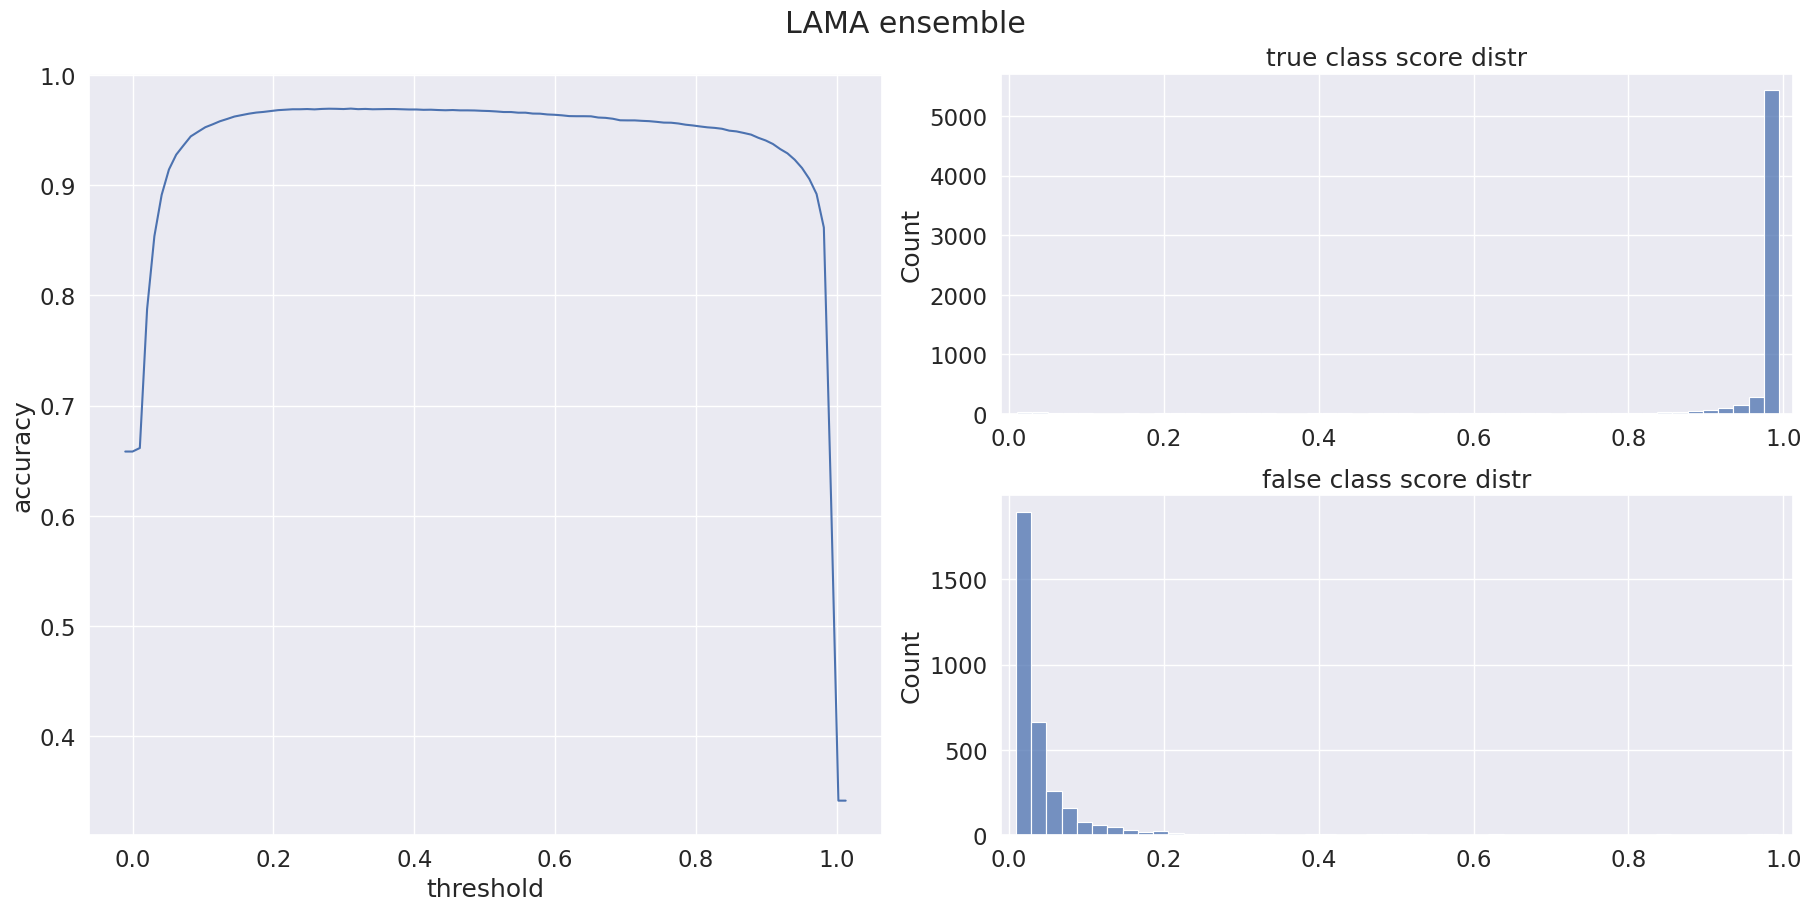

max acc: 0.970
class 1 prop : 0.6584


0.9696

In [75]:
from dialogue_sim.utils import plot_pairwaise_class

preds = test_pred.data[:, 0]
plot_pairwaise_class(preds, np.array(test_df.target), 'LAMA ensemble')

In [9]:
from sklearn.metrics import roc_auc_score

from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

automl = TabularAutoML(
    task = Task(
        name = 'binary',
        metric = max_acc,
        greater_is_better = True,
    )
)
oof_pred = automl.fit_predict(
    train_df,
    roles = {'target': 'target', 'drop' : ['FFN', 'GRU', 'LSTM']},
    verbose = 1
)
test_pred = automl.predict(test_df)

[13:27:11] Stdout logging level is INFO.
[13:27:11] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[13:27:11] Task: binary

[13:27:11] Start automl preset with listed constraints:
[13:27:11] - time: 3600.00 seconds
[13:27:11] - CPU: 4 cores
[13:27:11] - memory: 16 GB

[13:27:11] Train data shape: (20000, 11)

[13:27:12] Layer 1 train process start. Time left 3598.57 secs
[13:27:12] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[13:27:14] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.85125
[13:27:14] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[13:27:14] Time left 3597.38 secs

[13:27:16] Selector_LightGBM fitting and predicting completed
[13:27:16] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[13:27:25] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.85685
[13:27:25] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[13:27:25] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tune

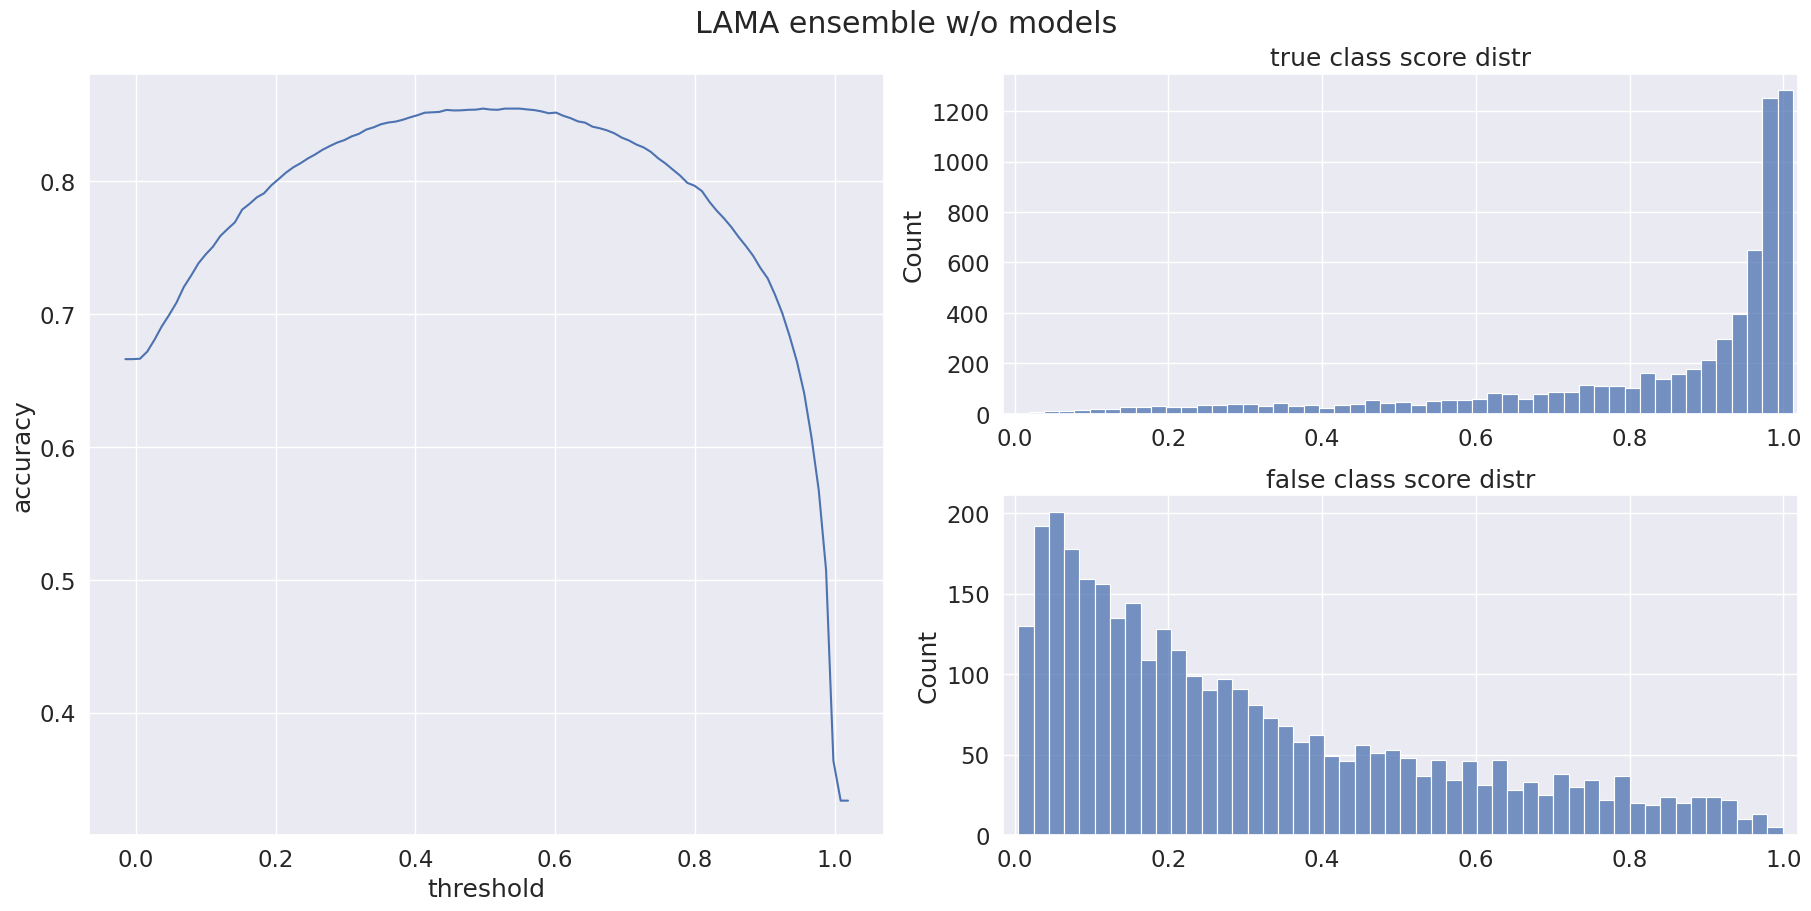

max acc: 0.855
class 1 prop : 0.6661


0.8546

In [11]:
from dialogue_sim.utils import plot_pairwaise_class

preds = test_pred.data[:, 0]
plot_pairwaise_class(preds, np.array(test_df.target), 'LAMA ensemble w/o models')